In [93]:
import json
import random
import numpy as np
from collections import defaultdict
from itertools import combinations
import datetime
import os

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt

from mip import Model, xsum, maximize, CBC, BINARY

In [94]:
CARDS_JSON = "data/labeled_cards.json"
DECKS_JSON = "data/one_piece_deck_lists.json"
KNOWN_SYNERGIES_JSON = "graphs/card_synergies.json"

with open(CARDS_JSON, "r") as f:
    cards_data = json.load(f)
with open(DECKS_JSON, "r") as f:
    decks_data = json.load(f)
with open(KNOWN_SYNERGIES_JSON, "r") as f:
    known_synergies_data = json.load(f)

print("Loaded", len(cards_data), "cards,", len(decks_data), "decks, and synergy data.")

Loaded 1301 cards, 1732 decks, and synergy data.


In [95]:
BANNED_CARDS = {"ST10-001", "OP03-098", "OP05-041", "ST06-015", "OP06-116", "OP2-024", "OP02-052"}
card_id_to_index = {c["id"]: i for i, c in enumerate(cards_data)}
leaders = [c for c in cards_data if c["type"] == "Leader"]

In [96]:
def get_card_colors(card):
    """Return a list of colors for this card (some leaders have 2)."""
    ccol = card.get("color", [])
    if isinstance(ccol, str):
        ccol = [ccol]
    return ccol

def find_leader_in_deck(deck):
    """Return the card_id of the leader in this deck (if any)."""
    for entry in deck:
        cid = list(entry.keys())[0]
        if any(l["id"] == cid for l in leaders):
            return cid
    return None

def deck_archetype(deck):
    """Return the archetype name of the deck's leader (if found)."""
    lid = find_leader_in_deck(deck)
    if not lid:
        return ""
    leader_card = next((l for l in leaders if l["id"] == lid), None)
    return leader_card.get("archetype", "").strip() if leader_card else ""

def deck_matches_color_archetype(deck, leader_color, leader_arche):
    """Check if deck's leader matches the given color/archetype (if specified)."""
    lid = find_leader_in_deck(deck)
    if not lid:
        return False
    leader_card = next((c for c in cards_data if c["id"] == lid), None)
    if not leader_card:
        return False
    deck_colors = get_card_colors(leader_card)
    deck_arch = leader_card.get("archetype", "").strip().lower()
    if not any(c in deck_colors for c in leader_color):
        return False
    return (deck_arch == leader_arche.lower()) if leader_arche else True

def gather_decks_for_color_archetype(leader_color, leader_arche, all_decks):
    """Return decks whose leader matches the given color/archetype; fallback to color only."""
    filtered = [d for d in all_decks if deck_matches_color_archetype(d, leader_color, leader_arche)]
    if filtered:
        return filtered

    # fallback: color only
    def deck_matches_color(deck, chosen_color):
        lid = find_leader_in_deck(deck)
        if not lid:
            return False
        lead_card = next((c for c in cards_data if c["id"] == lid), None)
        if not lead_card:
            return False
        return any(x in get_card_colors(lead_card) for x in chosen_color)

    return [d for d in all_decks if deck_matches_color(d, leader_color)]

In [97]:
def parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True):
    """Parse known synergy links from JSON, returning a dict { (src, tgt): weight }."""
    synergy_edges = defaultdict(float)
    for ln in known_synergies_data.get("links", []):
        src, tgt = ln["source"], ln["target"]
        if src in card_id_to_index and tgt in card_id_to_index:
            synergy_edges[(src, tgt)] += synergy_weight
            if treat_as_undirected:
                synergy_edges[(tgt, src)] += synergy_weight
    return synergy_edges

def build_synergy_graph(relevant_decks, leader_arche, target_colors, synergy_weight=2.0, known_synergy_edges=None):
    """
    Build an undirected weighted graph where edges represent synergy 
    (co-occurrence in the same deck). Additional known synergy edges can be added.
    """
    G = nx.Graph()
    all_ids = {c["id"] for c in cards_data if any(col in c["color"] for col in target_colors)}
    G.add_nodes_from(all_ids)

    for deck in relevant_decks:
        lid = find_leader_in_deck(deck)
        if not lid:
            continue
        deck_arch = deck_archetype(deck)
        w_factor = synergy_weight if deck_arch.lower() == leader_arche.lower() else 1.0
        deck_cards = []
        for entry in deck:
            cid = list(entry.keys())[0]
            cnt = entry[cid]
            if cid == lid or cid not in all_ids:
                continue
            # add multiple copies of the same card to reflect synergy weighting
            for _ in range(cnt):
                deck_cards.append(cid)
        # now add edges for all pairs
        for i in range(len(deck_cards)):
            for j in range(i+1, len(deck_cards)):
                a, b = deck_cards[i], deck_cards[j]
                if a == b:
                    continue
                if G.has_edge(a, b):
                    G[a][b]["weight"] += w_factor
                else:
                    G.add_edge(a, b, weight=w_factor)

    # add known synergy edges
    if known_synergy_edges:
        for (src, tgt), w in known_synergy_edges.items():
            if src not in all_ids or tgt not in all_ids:
                continue
            if src in BANNED_CARDS or tgt in BANNED_CARDS:
                continue
            if G.has_edge(src, tgt):
                G[src][tgt]["weight"] += w
            else:
                G.add_edge(src, tgt, weight=w)

    return G

def compute_card_frequency(relevant_decks):
    """Return how many times each card (non-leader) appears across relevant decks."""
    freq_map = defaultdict(int)
    all_ids = {c["id"] for c in cards_data}
    for d in relevant_decks:
        lid = find_leader_in_deck(d)
        for entry in d:
            cid = list(entry.keys())[0]
            cnt = entry[cid]
            if cid in all_ids and cid != lid and cnt > 0:
                freq_map[cid] += cnt
    return freq_map

def compute_archetype_usage_ratio(relevant_decks, leader_arche):
    """
    For decks matching this archetype, find how often each card appears 
    across these decks (by fraction of decks).
    """
    arche_decks = [d for d in relevant_decks if deck_archetype(d).lower() == leader_arche.lower()]
    deck_count = len(arche_decks)
    usage_count = defaultdict(int)
    if deck_count == 0:
        return {c["id"]: 0.0 for c in cards_data}

    for d in arche_decks:
        lid = find_leader_in_deck(d)
        unique_cards = set()
        for entry in d:
            cid = list(entry.keys())[0]
            cnt = entry[cid]
            if cid != lid and cnt > 0:
                unique_cards.add(cid)
        for cid in unique_cards:
            usage_count[cid] += 1

    return {c["id"]: (usage_count[c["id"]] / deck_count) for c in cards_data}

In [98]:
def gather_all_traits(cards_data):
    traits_set = set()
    for c in cards_data:
        for t in c.get("traits", []):
            traits_set.add(t)
    return sorted(traits_set)

ALL_TRAITS = gather_all_traits(cards_data)
trait2idx = {t: i for i, t in enumerate(ALL_TRAITS)}
NUM_TRAITS = len(trait2idx)

def multi_hot_trait_vector(card):
    vec = np.zeros(NUM_TRAITS, dtype=np.float32)
    for t in card.get("traits", []):
        if t in trait2idx:
            vec[trait2idx[t]] = 1.0
    return vec

# Build a PyG Data object
def build_node_feature_with_traits(card, archetype_usage_map):
    cost_val = float(card.get("cost", 0))
    power_val = float(card.get("power", 0))
    ctr_val = float(card.get("counter", 0))
    arch_use = archetype_usage_map.get(card["id"], 0.0)  # fraction
    trait_vec = multi_hot_trait_vector(card)

    # base: cost, power, counter, usage
    base_features = np.array([cost_val, power_val, ctr_val, arch_use], dtype=np.float32)
    return np.concatenate((base_features, trait_vec))

def build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map):
    """Return (PyG Data object, node_labels) for training the GNN."""
    edges, weights, node_features, usage_list = [], [], [], []

    for c in cards_data:
        node_features.append(build_node_feature_with_traits(c, archetype_usage_map))
        usage_list.append(freq_map.get(c["id"], 0))

    x_tensor = torch.tensor(node_features, dtype=torch.float)
    node_labels = np.array(usage_list, dtype=np.float32)

    for u, v, data_attr in synergy_graph.edges(data=True):
        if u in card_id_to_index and v in card_id_to_index:
            ui = card_id_to_index[u]
            vi = card_id_to_index[v]
            w = data_attr["weight"]
            edges.append([ui, vi])
            edges.append([vi, ui])
            weights.append(w)
            weights.append(w)

    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_weight = torch.tensor(weights, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,), dtype=torch.float)

    data_pyg = Data(x=x_tensor, edge_index=edge_index)
    data_pyg.edge_weight = edge_weight
    return data_pyg, node_labels

In [99]:
class MultiTaskGNN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim=64, emb_dim=32, dropout=0.3, num_layers=3):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = torch.nn.Dropout(dropout)
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, emb_dim)
        self.node_head = torch.nn.Linear(emb_dim, 1)
        self.synergy_mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * emb_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(h, edge_index)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv3(h, edge_index)
        h = F.relu(h)
        h = self.dropout(h)
        node_score = self.node_head(h).squeeze(-1)  # shape (num_nodes,)
        return h, node_score

    def predict_synergy(self, hu, hv):
        inp = torch.cat([hu, hv], dim=-1)
        return self.synergy_mlp(inp).squeeze(-1)

def sample_negative_edges(edge_index, num_nodes, num_neg):
    """Random negative edges that are not in the graph."""
    existing = set()
    E = edge_index.shape[1]
    for i in range(E):
        u = edge_index[0, i].item()
        v = edge_index[1, i].item()
        existing.add((u, v))

    neg = []
    attempts = 0
    while len(neg) < num_neg and attempts < 500000:
        attempts += 1
        a = random.randint(0, num_nodes - 1)
        b = random.randint(0, num_nodes - 1)
        if a == b:
            continue
        if (a, b) in existing:
            continue
        neg.append((a, b))
    return neg

def train_gnn(model, data, node_labels_np, epochs=50, lr=0.01, neg_factor=2.0):
    """
    Train the GNN with a node-level objective (MSE to card frequency) plus synergy edges.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    mean_val = node_labels_np.mean()
    std_val = node_labels_np.std() if node_labels_np.std() > 1e-9 else 1.0
    node_labels_norm = (node_labels_np - mean_val) / std_val
    node_labels_t = torch.tensor(node_labels_norm, dtype=torch.float, device=device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        node_emb, node_score = model(data)

        # Node-level loss
        loss_node = F.mse_loss(node_score, node_labels_t)

        # Synergy loss
        # For each positive edge, synergy ~ log(1 + weight). Then sample negative edges
        pos_u, pos_v, pos_w = [], [], []
        E = data.edge_index.shape[1]
        for i in range(0, E, 2):  # each undirected edge is stored twice
            u = data.edge_index[0, i].item()
            v = data.edge_index[1, i].item()
            w = data.edge_weight[i].item()
            pos_u.append(u)
            pos_v.append(v)
            pos_w.append(np.log1p(w))

        loss_synergy = 0.0
        if len(pos_u) > 0:
            pos_u_t = torch.tensor(pos_u, dtype=torch.long, device=device)
            pos_v_t = torch.tensor(pos_v, dtype=torch.long, device=device)
            pos_w_t = torch.tensor(pos_w, dtype=torch.float, device=device)

            num_neg = int(len(pos_u) * neg_factor)
            neg_edges = sample_negative_edges(data.edge_index, data.x.shape[0], num_neg)
            if neg_edges:
                neg_u = [p[0] for p in neg_edges]
                neg_v = [p[1] for p in neg_edges]
                neg_u_t = torch.tensor(neg_u, dtype=torch.long, device=device)
                neg_v_t = torch.tensor(neg_v, dtype=torch.long, device=device)
                neg_w_t = torch.zeros(len(neg_edges), dtype=torch.float, device=device)

                all_u = torch.cat([pos_u_t, neg_u_t], dim=0)
                all_v = torch.cat([pos_v_t, neg_v_t], dim=0)
                all_w = torch.cat([pos_w_t, neg_w_t], dim=0)

                hu = node_emb[all_u]
                hv = node_emb[all_v]
                synergy_pred = model.predict_synergy(hu, hv)
                loss_synergy = F.mse_loss(synergy_pred, all_w)
            else:
                hu = node_emb[pos_u_t]
                hv = node_emb[pos_v_t]
                synergy_pred = model.predict_synergy(hu, hv)
                loss_synergy = F.mse_loss(synergy_pred, pos_w_t)

        # total loss
        loss = loss_node + loss_synergy
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - NodeLoss: {loss_node.item():.4f}, "
                  f"SynergyLoss: {loss_synergy:.4f}, Total: {loss.item():.4f}")

    return model, mean_val, std_val

def build_synergy_matrix(model, data, freq_map, node_labels_np, mean_val, std_val):
    """
    Use trained GNN to produce:
      - synergy_matrix[i, j]: synergy prediction between cards i & j
      - node_score[i]: (rescaled) frequency prediction
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        node_emb, node_score_t = model(data)

    node_emb = node_emb.cpu()
    node_score = node_score_t.cpu().numpy()
    node_score = node_score * std_val + mean_val  # inverse normalization

    # Adjust node_score for rarely used cards
    # (optionally penalize cards with zero frequency in the data)
    for i, c in enumerate(cards_data):
        if freq_map.get(c["id"], 0) == 0:
            node_score[i] -= 2.0

    num_cards = len(cards_data)
    synergy_matrix = np.zeros((num_cards, num_cards), dtype=np.float32)

    # synergy_value function
    def synergy_value(i, j):
        hi = node_emb[i].unsqueeze(0).to(device)
        hj = node_emb[j].unsqueeze(0).to(device)
        sv = model.predict_synergy(hi, hj)
        return sv.item()

    # Fill synergy_matrix
    for i in range(num_cards):
        for j in range(i+1, num_cards):
            sv = synergy_value(i, j)
            synergy_matrix[i, j] = sv
            synergy_matrix[j, i] = sv
        # diagonal = node score
        synergy_matrix[i, i] = max(0.1, node_score[i])
    return synergy_matrix, node_score

In [100]:
def save_model(model, filename):
    """
    Save the PyTorch model state dict to 'models/{filename}'.
    If a file with the given name already exists, it is moved to an archive folder.
    """
    models_dir = "models"
    archive_dir = os.path.join(models_dir, "archive")
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    file_path = os.path.join(models_dir, filename)
    if os.path.exists(file_path):
        if not os.path.exists(archive_dir):
            os.makedirs(archive_dir)
        # Move the file using os.rename instead of shutil.move
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        archived_file_path = os.path.join(archive_dir, f"{timestamp}_{filename}")
        os.rename(file_path, archived_file_path)
        print("Existing model moved to archive: " + archived_file_path)
    torch.save(model.state_dict(), file_path)
    print("Model saved to " + file_path)

def load_model(model, filename):
    """
    Load the PyTorch model state dict from 'models/{filename}'.
    """
    
    file_path = os.path.join("models", filename)
    if os.path.exists(file_path):
        model.load_state_dict(torch.load(file_path))
        print("Model loaded from " + file_path)
    else:
        print("Model file " + file_path + " not found.")
    return model

In [101]:
def train_and_build_synergy(leader_id=None):
    """
    1) Build synergy graph using either all decks or relevant decks for leader_id
    2) Train GNN
    3) Create synergy_matrix, node_score from the model
    Returns synergy_matrix, node_score
    """
    if leader_id is not None:
        # find leader color/arche
        leader_card = next((c for c in leaders if c["id"] == leader_id), None)
        if not leader_card:
            raise ValueError(f"Leader ID {leader_id} not found!")
        leader_color = get_card_colors(leader_card)
        leader_arche = leader_card.get("archetype", "").strip()
        relevant_decks = gather_decks_for_color_archetype(leader_color, leader_arche, decks_data)
        if not relevant_decks:
            # fallback to all decks
            relevant_decks = decks_data
        known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True)
        synergy_graph = build_synergy_graph(
            relevant_decks, 
            leader_arche, 
            synergy_weight=2.0, 
            known_synergy_edges=known_synergy_edges
        )
        freq_map = compute_card_frequency(relevant_decks)
        archetype_usage_map = compute_archetype_usage_ratio(relevant_decks, leader_arche)
    else:
        # "General" approach using all decks
        relevant_decks = decks_data
        dummy_leader = leaders[0]
        dummy_arche = dummy_leader.get("archetype", "").strip()
        known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True)
        synergy_graph = build_synergy_graph(
            relevant_decks, 
            dummy_arche, 
            synergy_weight=2.0, 
            known_synergy_edges=known_synergy_edges
        )
        freq_map = compute_card_frequency(relevant_decks)
        archetype_usage_map = compute_archetype_usage_ratio(relevant_decks, dummy_arche)

    # Build PyG dataset
    data_pyg, node_labels_np = build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map)

    # Train GNN
    in_dim = 4 + NUM_TRAITS
    model = MultiTaskGNN(in_dim=in_dim, hidden_dim=64, emb_dim=32, dropout=0.3, num_layers=3)
    model, mean_val, std_val = train_gnn(model, data_pyg, node_labels_np, epochs=50, lr=0.01, neg_factor=2.0)
    
    # Save the trained model (e.g. using filename "gnn_model.pth")
    save_model(model, mean_val, std_val, "gnn_model.pth")

    # Build synergy_matrix using the trained model
    synergy_matrix, node_score = build_synergy_matrix(model, data_pyg, freq_map, node_labels_np, mean_val, std_val)
    return synergy_matrix, node_score, relevant_decks

In [ ]:
def gather_decks_for_leader_archetype(target_leader_id, all_decks):
    """
    Filter decks to include only those whose leader shares at least one color
    and has the same archetype (case-insensitive) as the target leader.
    """
    target_leader = next((c for c in cards_data if c["id"] == target_leader_id), None)
    if not target_leader:
        raise ValueError(f"Target leader {target_leader_id} not found!")
    target_colors = set(get_card_colors(target_leader))
    target_arche = target_leader.get("archetype", "").strip().lower()
    
    relevant_decks = []
    for deck in all_decks:
        deck_leader_id = find_leader_in_deck(deck)
        if not deck_leader_id:
            continue
        deck_leader = next((c for c in cards_data if c["id"] == deck_leader_id), None)
        if not deck_leader:
            continue
        deck_colors = set(get_card_colors(deck_leader))
        deck_arche = deck_leader.get("archetype", "").strip().lower()
        if deck_arche == target_arche and (target_colors & deck_colors):
            relevant_decks.append(deck)
    return relevant_decks

def train_and_build_synergy_per_leader(target_leader_id):
    """
    Train a GNN model and build a synergy matrix using only decks whose leaders
    share at least one color and have the same archetype as the target leader.
    """
    # Use the custom filtering function.
    relevant_decks = gather_decks_for_leader_archetype(target_leader_id, decks_data)
    if not relevant_decks:
        print("No decks match the target leader criteria; falling back to all decks.")
        relevant_decks = decks_data

    target_leader = next((c for c in cards_data if c["id"] == target_leader_id), None)
    target_arche = target_leader.get("archetype", "").strip() if target_leader else ""
    target_color = get_card_colors(target_leader)

    known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True)
    synergy_graph = build_synergy_graph(relevant_decks, target_arche, target_color, synergy_weight=2.0, known_synergy_edges=known_synergy_edges)
    freq_map = compute_card_frequency(relevant_decks)
    archetype_usage_map = compute_archetype_usage_ratio(relevant_decks, target_arche)
    
    # Build the PyG dataset.
    data_pyg, node_labels_np = build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map)
    
    # Train the GNN.
    in_dim = 4 + NUM_TRAITS
    model = MultiTaskGNN(in_dim=in_dim, hidden_dim=64, emb_dim=32, dropout=0.3, num_layers=3)
    model, mean_val, std_val = train_gnn(model, data_pyg, node_labels_np, epochs=100, lr=0.01, neg_factor=2.0)
    
    # Save the model.
    save_model(model, f"gnn_model_{target_leader_id}.pth")
    
    # Build the synergy matrix.
    synergy_matrix, node_score = build_synergy_matrix(model, data_pyg, freq_map, node_labels_np, mean_val, std_val)
    return synergy_matrix, node_score, relevant_decks

In [103]:
def evaluate_synergy_prediction_accuracy(model, data, known_synergy_data, threshold=0.0):
    """
    Example synergy accuracy measure (UF1).
    - 'known_synergy_data' is a dict { (src, tgt): weight } from parse_known_synergies
    - Compare sign or rank of predicted synergy vs. ground-truth synergy?
      For illustration, we do a simple MSE on edges in known_synergy_data.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    data = data.to(device)

    with torch.no_grad():
        node_emb, _ = model(data)

    # build a list of (predicted, actual) for known synergy edges
    preds, actuals = [], []
    for (src, tgt), w in known_synergy_data.items():
        if src in card_id_to_index and tgt in card_id_to_index:
            i = card_id_to_index[src]
            j = card_id_to_index[tgt]
            if i >= len(cards_data) or j >= len(cards_data):
                continue
            hi = node_emb[i].unsqueeze(0)
            hj = node_emb[j].unsqueeze(0)
            pred = model.predict_synergy(hi, hj).item()
            preds.append(pred)
            actuals.append(np.log1p(w))  # or w directly

    if len(preds) == 0:
        print("No known synergy edges found in the data for evaluation.")
        return

    preds = np.array(preds)
    actuals = np.array(actuals)
    mse = ((preds - actuals)**2).mean()
    print(f"[UF1] Synergy Prediction MSE on Known Synergy Edges: {mse:.4f}")

def plot_deck_cost_distribution(deck, title="Deck Cost Distribution"):
    """Plot the cost distribution of the deck."""
    cost_count = defaultdict(int)
    for i, copies in enumerate(deck):
        if copies > 0:
            cst = cards_data[i].get("cost", 0)
            cost_count[cst] += copies
    costs = sorted(cost_count.keys())
    freqs = [cost_count[c] for c in costs]

    plt.figure()
    plt.bar([str(c) for c in costs], freqs)
    plt.xlabel("Cost")
    plt.ylabel("Number of Copies")
    plt.title(title)
    plt.show()

def print_deck_list(deck, leader_id):
    """Print final decklist in a human-readable form."""
    leader_card = next((c for c in cards_data if c["id"] == leader_id), None)
    print(f"=== DECK for Leader {leader_id} ({leader_card.get('name','Unknown')}) ===")
    total = 0
    for i, copies in enumerate(deck):
        if copies > 0:
            cid = cards_data[i]["id"]
            name = cards_data[i]["name"]
            print(f"{copies}x {cid} - {name}")
            total += copies
    print(f"Total non-leader cards: {total}")

def evaluate_deck_vs_meta(deck, relevant_decks):
    """
    Simple comparison to meta (UF2, UF3):
    - how many times each card appears in meta?
    - is the cost curve or trait distribution similar to meta averages?
    More advanced tests could compare actual win rates.
    """
    # 1) Compare card usage frequency in deck vs. meta frequency
    meta_freq = compute_card_frequency(relevant_decks)
    deck_freq_map = {}
    for i, copies in enumerate(deck):
        if copies > 0:
            cid = cards_data[i]["id"]
            deck_freq_map[cid] = copies

    # Print top used cards in meta vs. deck
    sorted_meta = sorted(meta_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    print("[UF2] Top 10 cards in meta (by raw usage):")
    for cid, freq in sorted_meta:
        nm = next((c["name"] for c in cards_data if c["id"] == cid), cid)
        print(f"{cid} - {nm}: {freq}")

    # Compare overlap
    deck_card_ids = {cards_data[i]["id"] for i, cpy in enumerate(deck) if cpy>0}
    meta_top_ids = [cid for cid, _ in sorted_meta]
    overlap = deck_card_ids.intersection(meta_top_ids)
    print(f"\nYour deck shares {len(overlap)} of the meta's top 10 used cards.\n")

def synergy_heatmap(deck, synergy_matrix, title="Deck Synergy Heatmap"):
    """
    Plot synergy heatmap among the cards that appear in the deck.
    """
    
    deck_idxs = [i for i, cpy in enumerate(deck) if cpy > 0]
    if not deck_idxs:
        print("No cards in deck to visualize synergy.")
        return

    sub_matrix = synergy_matrix[np.ix_(deck_idxs, deck_idxs)]
    plt.figure(figsize=(8,6))
    plt.imshow(sub_matrix, aspect='auto', origin='upper', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Card index in deck")
    plt.ylabel("Card index in deck")
    plt.show()

In [ ]:
def evaluate_deck(deck, synergy_matrix, node_score, singleton_penalty=10.0, max_singleton_ratio=0.3):
    """
    Evaluate the deck quality by summing the node scores and synergy contributions.
    Then, if the fraction of singleton cards exceeds max_singleton_ratio, apply a penalty.
    """
    # Calculate base score: node score + synergy score.
    total_score = sum(node_score[i] * deck[i] for i in range(len(deck)))
    synergy_score = 0.0
    for i in range(len(deck)):
        for j in range(i+1, len(deck)):
            synergy_score += synergy_matrix[i, j] * deck[i] * deck[j]
    base_score = total_score + synergy_score

    # Count singleton cards.
    total_copies = sum(deck)
    num_singletons = sum(1 for count in deck if count == 1)
    ratio = num_singletons / total_copies if total_copies > 0 else 0

    # Apply penalty if ratio exceeds allowed threshold.
    penalty = 0.0
    if ratio > max_singleton_ratio:
        penalty = singleton_penalty * (ratio - max_singleton_ratio) * total_copies

    return base_score - penalty

def greedy_initial_deck(valid_indices, node_score, deck_size, max_copies):
    """
    Create an initial deck by assigning copies to cards (from the valid pool)
    in descending order of node_score until the deck size is reached.
    """
    deck = [0] * len(cards_data)
    sorted_indices = sorted(valid_indices, key=lambda i: node_score[i], reverse=True)
    remaining = deck_size
    for i in sorted_indices:
        copies = min(max_copies, remaining)
        deck[i] = copies
        remaining -= copies
        if remaining <= 0:
            break

    print(f"Initial deck: {sum(deck)} cards, {remaining} remaining")

    return deck

def local_search_deck(initial_deck, synergy_matrix, node_score, iterations=1000,
                      singleton_penalty=10.0, max_singleton_ratio=0.3,
                      deck_size=50, max_copies=4):
    """
    Use local search to iteratively improve the deck.
    In each iteration, a random move (remove one copy of a card and add one copy of another)
    is performed, and the move is accepted if it improves the evaluated score.
    A small chance of accepting a worse move can help escape local optima.
    """
    current_deck = initial_deck[:]
    best_deck = initial_deck[:]
    best_score = evaluate_deck(current_deck, synergy_matrix, node_score, singleton_penalty, max_singleton_ratio)
    
    for it in range(iterations):
        neighbor = current_deck[:]
        # Choose a random card with at least one copy to remove.
        nonzero = [i for i, count in enumerate(neighbor) if count > 0]
        if not nonzero:
            continue
        remove_idx = random.choice(nonzero)
        neighbor[remove_idx] -= 1
        
        # Choose a random card to add, ensuring it doesn't exceed max_copies.
        possible_add = [i for i in range(len(neighbor)) if neighbor[i] < max_copies]
        if not possible_add:
            continue
        add_idx = random.choice(possible_add)
        neighbor[add_idx] += 1
        
        # Ensure the deck size remains constant.
        if sum(neighbor) != deck_size:
            continue
        
        neighbor_score = evaluate_deck(neighbor, synergy_matrix, node_score, singleton_penalty, max_singleton_ratio)
        if neighbor_score > best_score:
            best_score = neighbor_score
            best_deck = neighbor[:]
            current_deck = neighbor[:]
            print(f"Card {remove_idx} removed, card {add_idx} added")
        else:
            # With a small probability, accept a worse solution.
            if random.random() < 0.05:
                current_deck = neighbor[:]

        # print every 10 iterations
        if (it+1) % 10 == 0:
            print(f"Iteration {it+1}/{iterations} - Best Score: {best_score:.2f}")
    
    return best_deck

def build_deck_local_search(target_leader_id, synergy_matrix, node_score,
                            deck_size=50, max_copies=4, iterations=1000,
                            singleton_penalty=10.0, max_singleton_ratio=0.3):
    """
    Build a deck using local search. First, limit the card pool to those valid
    for the given leader (e.g. matching leader colors). Then, initialize a deck using a greedy method,
    and refine it with iterative improvement while penalizing decks with too many singletons.
    """
    # Build the valid card pool for the target leader.
    target_leader = next((c for c in cards_data if c["id"] == target_leader_id), None)
    if not target_leader:
        raise ValueError("Leader not found")
    leader_color = set(get_card_colors(target_leader))
    
    valid_indices = []
    for i, card in enumerate(cards_data):
        if card["id"] in BANNED_CARDS:
            continue
        if card["type"] == "Leader":
            continue
        card_colors = set(get_card_colors(card))
        if leader_color & card_colors:  # at least one color overlaps
            valid_indices.append(i)
    
    # Create an initial deck using a greedy approach.
    initial_deck = greedy_initial_deck(valid_indices, node_score, deck_size, max_copies)
    # Refine the deck using local search.
    best_deck = local_search_deck(initial_deck, synergy_matrix, node_score, iterations,
                                  singleton_penalty, max_singleton_ratio,
                                  deck_size, max_copies)
    return best_deck

In [105]:
target_leader_id = "OP01-001"  # Zoro leader, for example

In [106]:
# print("1a) Train GNN & Build Synergy Matrix ...")
# synergy_matrix, node_score, relevant_decks = None, None, None
# synergy_matrix, node_score, relevant_decks = train_and_build_synergy(target_leader_id)

In [107]:
print("1b) Train GNN & Build Synergy Matrix Leader-specific ...")
synergy_matrix, node_score, relevant_decks = None, None, None
synergy_matrix, node_score, relevant_decks = train_and_build_synergy_per_leader(target_leader_id)

1b) Train GNN & Build Synergy Matrix Leader-specific ...
Epoch 10/50 - NodeLoss: 55.9111, SynergyLoss: 21.4749, Total: 77.3860
Epoch 20/50 - NodeLoss: 4.0798, SynergyLoss: 4.6046, Total: 8.6844
Epoch 30/50 - NodeLoss: 2.1918, SynergyLoss: 3.1158, Total: 5.3076
Epoch 40/50 - NodeLoss: 1.4357, SynergyLoss: 3.1293, Total: 4.5651
Epoch 50/50 - NodeLoss: 1.0936, SynergyLoss: 2.7384, Total: 3.8320
Existing model moved to archive: models\archive\20250307_152959_gnn_model_OP01-001.pth
Model saved to models\gnn_model_OP01-001.pth


In [108]:
print("\n2) Evaluate Synergy Prediction Accuracy (UF1) ...")
known_synergy_edges = parse_known_synergies(known_synergies_data, synergy_weight=5.0, treat_as_undirected=True)
dummy_leader_card = next((c for c in leaders if c["id"] == target_leader_id), None)
leader_arche = dummy_leader_card.get("archetype", "").strip()
leader_colors = get_card_colors(dummy_leader_card)
synergy_graph = build_synergy_graph(relevant_decks, leader_arche, target_colors=leader_colors, synergy_weight=2.0, known_synergy_edges=known_synergy_edges)
freq_map = compute_card_frequency(relevant_decks)
archetype_usage_map = compute_archetype_usage_ratio(relevant_decks, leader_arche)
data_pyg, node_labels_np = build_pyg_data(cards_data, synergy_graph, freq_map, archetype_usage_map)

# Load the saved model for evaluation (alternatively, if you have the trained model in memory, use that)
in_dim = 4 + NUM_TRAITS
eval_model = MultiTaskGNN(in_dim=in_dim, hidden_dim=64, emb_dim=32, dropout=0.3, num_layers=3)
eval_model = load_model(eval_model, f"gnn_model_{target_leader_id}.pth")
evaluate_synergy_prediction_accuracy(eval_model, data_pyg, known_synergy_edges)


2) Evaluate Synergy Prediction Accuracy (UF1) ...
Model loaded from models\gnn_model_OP01-001.pth
[UF1] Synergy Prediction MSE on Known Synergy Edges: 2.8314


In [117]:
best_deck = build_deck_local_search(target_leader_id, synergy_matrix, node_score,
                                    deck_size=50, max_copies=4, iterations=2000,
                                    singleton_penalty=10.0, max_singleton_ratio=0.3)

Initial deck: 50 cards, 0 remaining
Card 2 removed, card 126 added
Card 2 removed, card 613 added
Iteration 10/2000 - Best Score: 282.30
Iteration 20/2000 - Best Score: 282.30
Iteration 30/2000 - Best Score: 282.30
Iteration 40/2000 - Best Score: 282.30
Iteration 50/2000 - Best Score: 282.30
Iteration 60/2000 - Best Score: 282.30
Iteration 70/2000 - Best Score: 282.30
Iteration 80/2000 - Best Score: 282.30
Iteration 90/2000 - Best Score: 282.30
Iteration 100/2000 - Best Score: 282.30
Iteration 110/2000 - Best Score: 282.30
Iteration 120/2000 - Best Score: 282.30
Iteration 130/2000 - Best Score: 282.30
Iteration 140/2000 - Best Score: 282.30
Iteration 150/2000 - Best Score: 282.30
Iteration 160/2000 - Best Score: 282.30
Iteration 170/2000 - Best Score: 282.30
Iteration 180/2000 - Best Score: 282.30
Iteration 190/2000 - Best Score: 282.30
Iteration 200/2000 - Best Score: 282.30
Iteration 210/2000 - Best Score: 282.30
Iteration 220/2000 - Best Score: 282.30
Iteration 230/2000 - Best Score

=== DECK for Leader OP01-001 (Roronoa Zoro) ===
2x OP01-030 - In 2 years!!! To Sabaody
4x OP01-026 - Gum-Gum Red Hawk
4x OP01-024 - Monkey D. Luffy
4x OP01-016 - Nami
4x OP01-006 - Otama
4x OP01-029 - Radical Beam!!
4x OP01-004 - Usopp
4x OP01-022 - Brook
4x OP01-017 - Nico Robin
4x OP01-013 - Sanji
4x OP01-027 - Round Table
4x OP01-120 - Shanks
2x OP01-012 - Sai
1x ST01-011 - Brook
1x OP04-013 - Pell
Total non-leader cards: 50


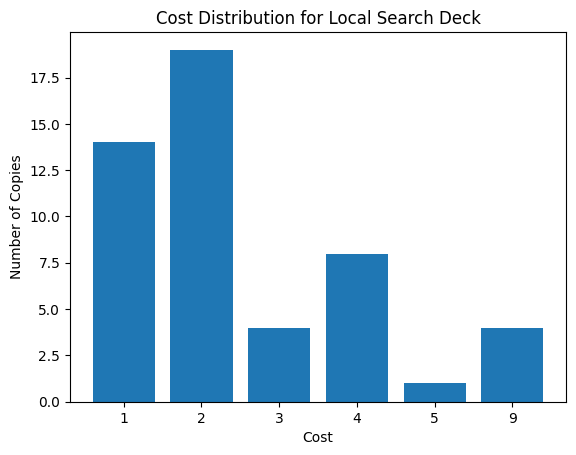

[UF2] Top 10 cards in meta (by raw usage):
OP01-025 - Roronoa Zoro: 652
OP01-006 - Otama: 650
OP02-015 - Makino: 458
OP02-005 - Curly Dadan: 452
OP01-016 - Nami: 421
P-013 - Gordon: 370
ST01-011 - Brook: 327
OP03-013 - Marco: 301
OP03-008 - Buggy: 295
OP01-029 - Radical Beam!!: 294

Your deck shares 4 of the meta's top 10 used cards.



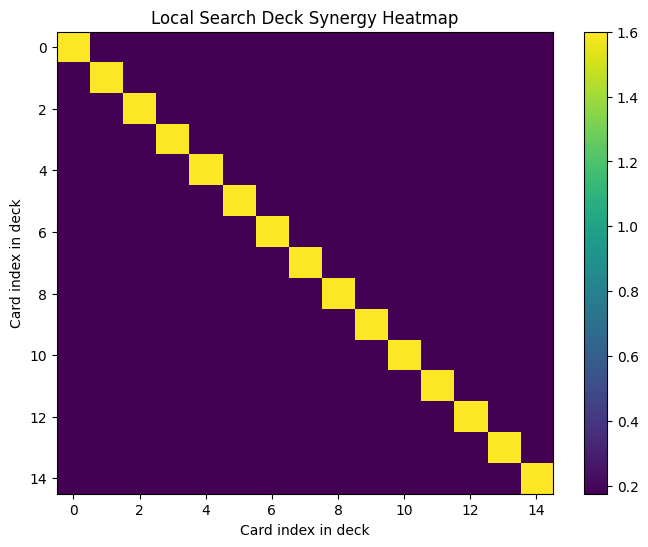

In [118]:
print_deck_list(best_deck, target_leader_id)
plot_deck_cost_distribution(best_deck, title="Cost Distribution for Local Search Deck")
evaluate_deck_vs_meta(best_deck, relevant_decks)
synergy_heatmap(best_deck, synergy_matrix, title="Local Search Deck Synergy Heatmap")

In [ ]:
# print("\n3) Solve MILP Deck Construction for Leader (UF2, UF3) ...")
# best_deck = build_deck_milp(target_leader_id, synergy_matrix, node_score)
# print_deck_list(best_deck, target_leader_id)
# plot_deck_cost_distribution(best_deck, title="Cost Distribution of GNN+MILP Deck")
# evaluate_deck_vs_meta(best_deck, relevant_decks)
# synergy_heatmap(best_deck, synergy_matrix, title="MILP Deck Synergy Heatmap")


3) Solve MILP Deck Construction for Leader (UF2, UF3) ...


In [116]:
print("\n4) (UF4) Adapting to new decks would involve re-running 'train_and_build_synergy()' on updated data.\n")


4) (UF4) Adapting to new decks would involve re-running 'train_and_build_synergy()' on updated data.



In [115]:
print("5) (UF5) Identify complex combos or underrepresented cards by analyzing synergy_graph or discrepancy.\n")

5) (UF5) Identify complex combos or underrepresented cards by analyzing synergy_graph or discrepancy.

